# TensorBoard

## Dependencies

Note: the following dependencies were **not included** in the project's requirements file:
* tensorflow
* tensorboard
* torch

In [3]:
# Load in the used dependencies
import os
import numpy as np
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data

### Hyperparameters

In [23]:
LOG_DIR = './population_backup/storage/experiment6/'
topology_id = 3333
overwrite = True
rm_duplicates = False  # Remove all samples with at least 'dup_columns' duplicate values
dup_columns = None  # Number of duplicated columns a single sample has before removal
filter_score = True  # Filter out samples having a fitness of min_fitness or more 
classify = False  # Classify the samples based on the connections

In [24]:
if topology_id in [2,3,222,3333]:
    min_fitness = 1  # GRU is capable of finding all targets
elif topology_id in [22]:
    min_fitness = 0.6  # Best score of 11/18
else:
    raise Exception(f"Add topology ID '{topology_id}'")

### Fetch

In [25]:
# Setup the header
head = ['fitness']
if topology_id in [1, 2, 3]:  # GRU populations
    head += ['bias_r', 'bias_z', 'bias_h',
             'weight_xr', 'weight_xz', 'weight_xh',
             'weight_hr', 'weight_hz', 'weight_hh']
elif topology_id in [22, 33]:  # SRU populations
    head += ['bias_h', 'weight_xh', 'weight_hh']
elif topology_id in [2222, 3333]:
    head += ['bias_z', 'bias_h',
             'weight_xz', 'weight_xh',
             'weight_hz', 'weight_hh']
elif topology_id in [222, 333]:
    head += ['delay', 'scale', 'resting']
else:
    raise Exception(f"Topology ID '{topology_id}' not supported!")

if topology_id in [1]:
    head += ['conn1', 'conn2']
elif topology_id in [2, 22, 222, 2222]:
    head += ['bias_rw', 'conn2']
elif topology_id in [3, 33, 333, 3333]:
    head += ['bias_rw', 'conn0', 'conn1', 'conn2']
else:
    raise Exception(f"Topology ID '{topology_id}' not supported!")

In [26]:
# Check if tsv files already exist
raw_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/topology_{topology_id}.csv')
data_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/data.tsv')
meta_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/meta.tsv')

# Load in the data (without header)
if not overwrite and os.path.exists(data_path):
    data = np.genfromtxt(data_path, delimiter='\t')
    meta = np.genfromtxt(meta_path, delimiter='\t')
else:
    raw = np.genfromtxt(raw_path, delimiter=',')[1:]
    data = raw[:,:-1]
    meta = raw[:,-1]
    np.savetxt(data_path, data, delimiter='\t')
    np.savetxt(meta_path, meta, delimiter='\t')

# Print shape:
print(f"Data shape: {data.shape}")
print(f"Meta shape: {meta.shape}")

Data shape: (110, 10)
Meta shape: (110,)


In [27]:
# Transform to pandas dataframe (easier to manipulate)
data_pd = pd.DataFrame(data, columns=head[1:])
meta_pd = pd.DataFrame(meta, columns=head[:1])

In [28]:
data_pd.head()

,bias_z,bias_h,weight_xz,weight_xh,weight_hz,weight_hh,bias_rw,conn0,conn1,conn2
0,1.974154,1.348243,0.778221,-2.102736,-0.795138,-0.855767,1.748139,3.706239,-2.057357,-4.008376
1,1.974154,1.307025,0.549468,-2.160010,-1.052036,-0.909041,1.601073,3.691729,-2.072557,-4.008376
2,1.974154,1.348243,0.466715,-2.204705,-1.234293,-0.909041,1.739919,3.691729,-2.072557,-4.578451
3,1.287508,-0.761263,0.873605,0.639503,-0.861772,0.847308,2.263972,5.384680,4.636644,-5.454408
4,1.287508,-0.761263,0.873605,0.639503,-0.861772,1.258658,2.263972,5.384680,4.636644,-5.454408


In [29]:
meta_pd.head()

,fitness
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


### Filter the data

In [30]:
# Filter out the complete duplicates
indices = data_pd.duplicated()
data_pd = data_pd[~indices.values]
meta_pd = meta_pd[~indices.values]
print(f"Data shape: {data_pd.shape}")
print(f"Meta shape: {meta_pd.shape}")

Data shape: (50, 10)
Meta shape: (50, 1)


In [31]:
# For example, if you want to see only fitnesses of 1 (perfect score).
if filter_score:
    indices = meta_pd >= min_fitness
    data_pd = data_pd[indices.values]
    meta_pd = meta_pd[indices.values]
    print(f"Data shape: {data_pd.shape}")
    print(f"Meta shape: {meta_pd.shape}")

Data shape: (50, 10)
Meta shape: (50, 1)


In [32]:
# Filter out all the samples that have at least one duplicate value (in each of its columns)
if rm_duplicates:
    indices = (meta_pd<0).astype(int).values.flatten()  # Little hack
    for h in head[1:]:
        indices += data_pd.duplicated(subset=h).astype(int).values

    # Remove all that exceed the set threshold
    data_pd = data_pd[indices < dup_columns]
    meta_pd = meta_pd[indices < dup_columns]
    print(f"Dropping duplicates that occur in {dup_columns} columns or more")
    print(f" > Data shape: {data_pd.shape}")
    print(f" > Meta shape: {meta_pd.shape}")

In [33]:
data_pd.head()

,bias_z,bias_h,weight_xz,weight_xh,weight_hz,weight_hh,bias_rw,conn0,conn1,conn2
0,1.974154,1.348243,0.778221,-2.102736,-0.795138,-0.855767,1.748139,3.706239,-2.057357,-4.008376
1,1.974154,1.307025,0.549468,-2.160010,-1.052036,-0.909041,1.601073,3.691729,-2.072557,-4.008376
2,1.974154,1.348243,0.466715,-2.204705,-1.234293,-0.909041,1.739919,3.691729,-2.072557,-4.578451
3,1.287508,-0.761263,0.873605,0.639503,-0.861772,0.847308,2.263972,5.384680,4.636644,-5.454408
4,1.287508,-0.761263,0.873605,0.639503,-0.861772,1.258658,2.263972,5.384680,4.636644,-5.454408


### Visualize the data

Remark: Symmetry in data clearly by conn1 (this is the connection between GRU node and output of the global network) 

Data shape: (50, 10)


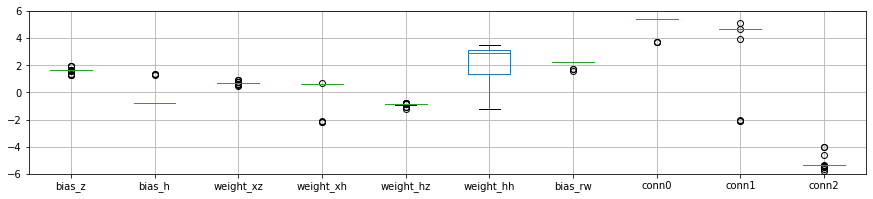

In [34]:
# indices = (data_pd['bias_rw'] >= 2) & (data_pd['conn2'] >= -3)
indices = (data_pd['bias_rw'] != 0)
temp = data_pd[indices.values]
print(f"Data shape: {temp.shape}")
plt.figure(figsize=(15,3))
temp.boxplot()
plt.ylim(-6,6)
plt.show()
plt.close()

In [35]:
for i, v in enumerate(temp.values):
    a = abs(v[3]-2.1088881375106086)
    b = abs(v[4]+2.819266855899976)
    if  a+b < 1:
        print(i, "-", a+b,"-", round(a,3), "-", round(b,3))

In [110]:
temp.head()

,bias_h,weight_xh,weight_hh,bias_rw,conn2
43710,-0.45688,-1.690133,-1.188066,3.000000,-2.579436
43715,-0.45688,-1.773253,-1.160458,2.659006,-2.383120
43728,-0.45688,-1.678492,-1.188066,3.000000,-2.579436
43864,-0.45688,-1.666019,-1.188066,3.000000,-2.579436
44091,-0.45688,-1.667454,-1.188066,3.000000,-2.579436


In [114]:
temp.values[1][4]

-2.383119722006138

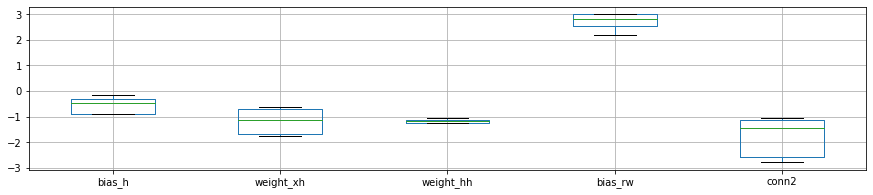

In [20]:
plt.figure(figsize=(15,3))
data_pd.boxplot()
plt.show()
plt.close()

In [36]:
def adapt_and_show(data, indices=None):
    data_temp = data
    if indices is not None: data_temp = data_temp[indices.values]
    print(f"Size: {data_temp.shape}")
    plt.figure(figsize=(15,5))
    for i, h in enumerate(head[1:]):
        plt.subplot(int(len(head)/6+1),6,i+1)
        sns.violinplot(data_temp[h])
        plt.title(h)
        if 'delay' in h:
            continue
        if 'bias' in h or 'resting' in h:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
        plt.yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

Size: (50, 10)


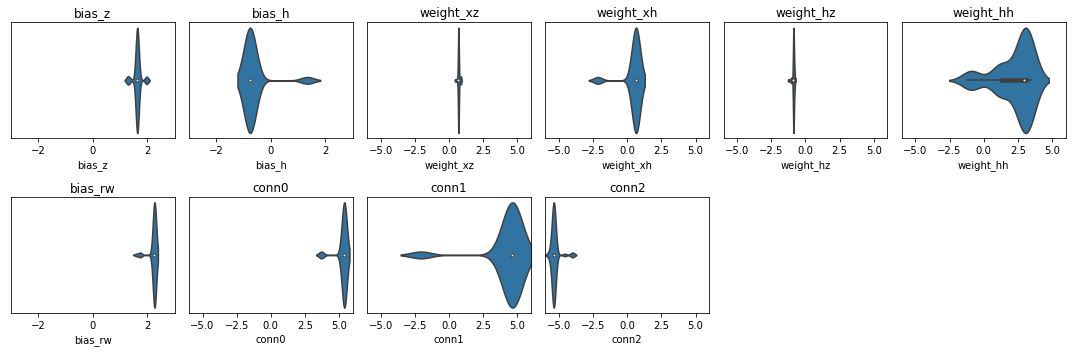

In [37]:
# indices = (data_pd['conn1'] > 0) & (data_pd['conn0'] > 0)
indices = None
adapt_and_show(data_pd, indices)

In [24]:
# h = 'bias_h'
# t = '$c_0$'
# plt.figure(figsize=(3,1.3))
# sns.violinplot(data_pd[h])
# plt.title(t)
# if 'bias' in h:
#     plt.xlim(-3,3)
# else:
#     plt.xlim(-6,6)
# plt.ylim(0)
# plt.yticks([])
# plt.xlabel('')
# plt.tight_layout()
# plt.savefig(f"delete_me/{h}.png", bbox_inches='tight', pad_inches=0.02)
# plt.show()
# plt.close()

### Add column

Add a class column, used for visualisation in the Projector.

In [363]:
def classify_connections(r):
    if r['conn0'] >= 0 and r['conn1'] >= 0:
        return "PP"  # Positive Positive
    elif r['conn0'] >= 0 and r['conn1'] < 0:
        return "PN"  # Positive Negative
    elif r['conn0'] < 0 and r['conn1'] >= 0:
        return "NP"  # Negative Positive
    else:
        return "NN"  # Negative Negative

In [364]:
classes = None
if classify:
    classes = data_pd.apply(lambda row: classify_connections(row), axis=1).values

### Format

Create labels for visualisation.

In [365]:
# Create better labels
meta_str = []
for d, m in zip(data_pd.values, meta_pd.values):
    s = [str(round(m[0], 2))]
    s += [str(round(x, 5))for x in d]
    meta_str.append(s)   
    
if classify:
    if 'classes' not in head: head.insert(0, 'classes')
    for i, m in enumerate(meta_str):
        meta_str[i].insert(0, classes[i])

# Example
print(f"Data example: \n> {data_pd.values[0]}")
print(f"Label example: \n> {meta_str[0]}")
print(f"For header: \n> {head}")

Data example: 
> [40.          1.7401337   0.338963    0.6201713  -4.08427156]
Label example: 
> ['1.0', '40.0', '1.74013', '0.33896', '0.62017', '-4.08427']
For header: 
> ['fitness', 'delay', 'scale', 'resting', 'bias_rw', 'conn2']


## Magic

Folder in which data is stored is "runs/topology_1" (always keep "runs"). Change this is you want to compare several configurations.

In [283]:
# Fire up the TensorBoard
writer = SummaryWriter(log_dir=f"runs/topology_{topology_id}")  # Overwrites if already exists
writer.add_embedding(data_pd.to_numpy(), meta_str, metadata_header=head)
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

# Tensorboard can be opened in separate tab: localhost:6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5308), started 4:45:41 ago. (Use '!kill 5308' to kill it.)